# Задание 5. Защита от модели-имитатора (Model Stealing)

Цель: Проверка уязвимости модели классификации к краже.

Задание:

﻿ ﻿1.﻿ ﻿Выполните model stealing attack, создавая локальную модель, которая имитирует поведение удалённой модели (через API). Предлагается проверять уязвимость на модели классификации на табличных данных.



В тестовом задании под удаленной моделью можно взять обученную модель из открытых источников (напр.  1, 2, 3) и развернуть локально. Под API подразумевается функция predict выбранной модели. (* Плюсом вам будет, если вы развернете реальное упрощенное веб API по шаблону )



Кроме вызова подобной функции, любое взаимодействие с моделью на первом этапе запрещено!


def requestModel(X):

  result = model.predict(X)

  return result



﻿ ﻿2.﻿ ﻿Определите меры защиты, чтобы снизить точность "украденной" модели. Это может включать в себя, например, дополнительную обработку датасетов для обучения модели, входных параметров API, выходных результатов функции.

## Выбор модели и загрузка

Мной была выбрана модель классификации видов вина на 5 классов https://huggingface.co/julien-c/wine-quality

Данная модель обучена на известном датасете и наследована от класса sklearn.Pipeline, что позволяет не заморачиваться с предобработкой и масштабированием данных, все происходит внутри. Однако не понятно (по крайней мере явно в карточке модели этой информации нет), какую архитектуру выбрал автор модели и как он ее обучал. Поэтому именно ее мы и попробуем сымитировать.

Accuracy исходной модели на всем датасете 0.6617

In [ ]:
import pandas as pd
import numpy as np
from huggingface_hub import hf_hub_download
from joblib import load
import warnings
warnings.filterwarnings('ignore')

## Информация о выборке и валидация исходной модели

In [ ]:
model = load(hf_hub_download(repo_id="julien-c/wine-quality", filename="sklearn_model.joblib"))
data_file = hf_hub_download(repo_id="julien-c/wine-quality", filename="winequality-red.csv")
winedf = pd.read_csv(data_file, sep=";")

X = winedf.drop(["quality"], axis=1)
Y = winedf["quality"]

print(X[:3])

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   

   alcohol  
0      9.4  
1      9.8  
2      9.8  


Сразу заметим что выборка несбалансированна

In [ ]:
# Посмотрим распеделение классов
y_series_y = pd.Series(Y)

print(y_series_y.value_counts())

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [ ]:
print(winedf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


Пропусков нет, масштаб данных разный. Масштабирование вшито в модель, это видно при включенных warnings.

In [ ]:
X.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


Попробуем потестировать модель

In [ ]:
# Эмуляция API
def requestModel(X):
    result = model.predict(X)
    return result

In [ ]:
print(requestModel(X[:3]))

[5 5 5]


Редкие классы вообще не предсказываются, класс номер 7 предсказан чуть менее чем наполовину, исходно его 199, мы нашли лишь 90

In [ ]:
y_begin = requestModel(X)

print("Initial model accuracy = ", np.round(model.score(X, Y), 4))

y_series = pd.Series(y_begin)

print("Class predictions:")
print(y_series.value_counts(),)

Initial model accuracy =  0.6617
Class predictions:
5    782
6    727
7     90
Name: count, dtype: int64


Попробуем визулизировать данные методом PCA

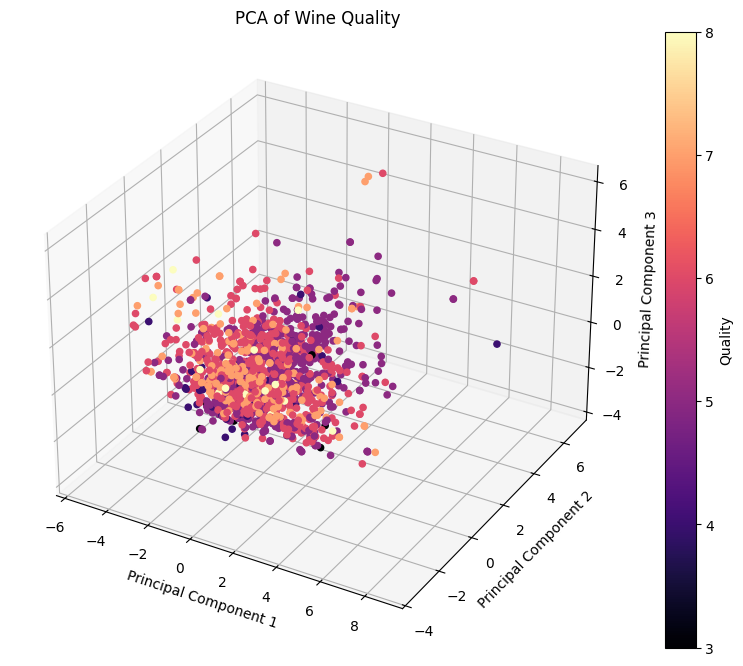

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Удалим целевую переменную 'quality' из данных для PCA
X = winedf.drop('quality', axis=1)

# Нормализация данных для визуализации
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Выполнение PCA с 3 компонентами
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)

# Создание DataFrame с результатами PCA
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])

# Добавление столбца 'quality' для визуализации
pca_df['Quality'] = winedf['quality']

# Визуализация результатов PCA в 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Создание 3D графика рассеяния
scatter = ax.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], pca_df['Principal Component 3'],
                     c=pca_df['Quality'], cmap='magma', alpha=1.0)

ax.set_title('PCA of Wine Quality')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(scatter, label='Quality')
plt.show()


Корреляции есть, но их мало и они запутанные.

Выборка мало того что несбалансированная, так еще и вся перемешанная

[Text(0.5, 0, 'fixed acidity'),
 Text(1.5, 0, 'volatile acidity'),
 Text(2.5, 0, 'citric acid'),
 Text(3.5, 0, 'residual sugar'),
 Text(4.5, 0, 'chlorides'),
 Text(5.5, 0, 'free sulfur dioxide'),
 Text(6.5, 0, 'total sulfur dioxide'),
 Text(7.5, 0, 'density'),
 Text(8.5, 0, 'pH'),
 Text(9.5, 0, 'sulphates'),
 Text(10.5, 0, 'alcohol'),
 Text(11.5, 0, 'quality')]

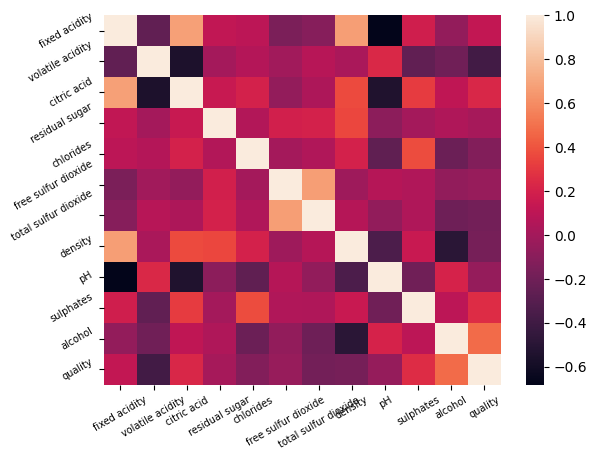

In [ ]:
import seaborn as sns
winecorr = winedf.corr()
s=sns.heatmap(winecorr)
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)

## Атака

Для генерации данных используем нормальное распределение.

Плюсы данного подхода
* Схожесть с оригинальными данными: Использование среднего и стандартного отклонения позволяет генерировать данные, которые похожи по статистическим характеристикам на исходные данные, что увеличивает вероятность получения осмысленных предсказаний от модели.
* Контролируемость: Можно задавать параметры распределения, чтобы данные были в рамках ожидаемого диапазона.
* Оперативность: Я понятия не имею какие должны быть значения признаков у вин, тем более помеченных цифрами, а не нормальными сортами, поэтому не нужно тратить время на выяснение у какого класса какие должны быть значения.

Минусы данного подхода
* Ограниченность: Если исходные данные не подчиняются нормальному распределению (например, имеют асимметрию, выбросы, категориальные признаки или сложные зависимости), то сгенерированные данные будут плохо отражать структуру исходного набора.
* Монотонность данных: Если использовать только нормальное распределение, модель может быстро выдать предсказания, сильно коррелирующие с реальными классами, но упустить редкие/крайние случаи, которые важны для подделки модели.
* Риск генерации некорректных данных: Если данные содержат физические ограничения (например, только положительные значения или целые числа), нормальное распределение может генерировать значения за пределами допустимого диапазона.

В целом, исходная модель и так предсказывает 3 класса из 6, не думаю что асимметрия или выбросы в исходном датасете имеют хоть какое-то значение.

In [ ]:
np.random.seed(100)
# Генерация данных для кражи
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

# Генерация данных с нормальным распределением
X_steal = np.random.normal(loc=mean, scale=std, size=(1599, X.shape[1]))

# В исходном датасете максимум 5 знаков после запятой
X_steal = np.round(X_steal, 5)

# Отправка запросов к API и сбор предсказаний
y_steal = np.array([requestModel(X_steal[i].reshape(1, -1))[0] for i in range(len(X_steal))])

# Проверка собранных данных
print(f"Shape of stolen dataset: {X_steal.shape}, {y_steal.shape}")
print(f"Sample labels: {y_steal[:10]}")

Shape of stolen dataset: (1599, 11), (1599,)
Sample labels: [5 6 5 5 6 5 5 5 5 5]


In [ ]:
print(X_steal[:10])

[[ 5.2740800e+00  5.8916000e-01  4.9552000e-01  2.1830000e+00
   1.3364000e-01  2.1252050e+01  5.3741290e+01  9.9473000e-01
   3.2818700e+00  7.0136000e-01  9.9350300e+00]
 [ 9.0770600e+00  4.2335000e-01  4.3005000e-01  3.4870000e+00
   8.2550000e-02  1.0319380e+01  8.0330590e+01  9.9592000e-01
   3.1385100e+00  9.3249000e-01  1.2065310e+01]
 [ 7.8812300e+00  3.7702000e-01  3.0691000e-01  3.8596100e+00
   1.2186000e-01  3.0112560e+01  3.5739440e+01  9.9685000e-01
   3.3454400e+00  4.1359000e-01  9.6172200e+00]
 [ 9.7407200e+00  6.6215000e-01  1.8218000e-01  4.2155600e+00
   7.9200000e-03  1.6912100e+00  5.9391400e+00  9.9572000e-01
   3.2079900e+00  6.5939000e-01  9.7700000e+00]
 [ 1.0581920e+01  2.1759000e-01  7.9490000e-02  3.0427100e+00
   1.1550000e-02  3.1254010e+01  7.3997900e+00  9.9571000e-01
   3.1660300e+00  5.1785000e-01  1.0538960e+01]
 [ 9.2035100e+00  3.7348000e-01  5.1430000e-01  2.4265900e+00
   4.5600000e-02  6.6540600e+00  4.7080730e+01  9.9720000e-01
   3.3132000e+00

In [ ]:
# Проверка API
test_sample = X_steal[:5]
print("API Output:", requestModel(test_sample))

API Output: [5 6 5 5 6]


Предсказания на сгенерированном датасете отражают разбалансированность предсказаний на исходном датасете, 7 класса стало еще меньше

In [ ]:
y_series_y = pd.Series(y_steal)

print(y_series_y.value_counts())

5    799
6    782
7     18
Name: count, dtype: int64


Обучим градиентный бустинг, посмотрим на качество

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

stolen_model = GradientBoostingClassifier(
    n_estimators=100,       # Количество деревьев в бустинге
    learning_rate=0.1,      # Скорость обучения
    max_depth=3,            # Максимальная глубина деревьев
    min_samples_split=2,     # Минимальное количество образцов для разделения узла
    min_samples_leaf=1,     # Минимальное количество образцов в листовом узле
    random_state=42         # Для воспроизводимости
)

stolen_model.fit(X_steal, y_steal)

GradientBoostingClassifier(random_state=42)

In [ ]:
# Проверка качества украденной модели
print("Accuracy on true test set:", np.round(stolen_model.score(X, Y), 4))

Accuracy on true test set: 0.6016


Краденная модель показала точность 0.6016 против 0.6617. Снижение accuracy примерно на 10%, атака явно удалась. Можно было бы аккуратнее сгенерировать данные, поточнее подобрать гиперпараметры градиентного бустинга, и возможно качество стало бы еще лучше.

## Варианты защиты

1) Ограничение на число запросов API. Если злоумышленнику не удастся собрать достаточное количество ответов модели, то ему будет значительно сложнее сходу угнать модель. Можно поставить общее ограничение, наример в 100 запросов, либо поставить 1 запрос в 10 секунд (тогда для создания копии нашего датасета понадобится более 4 часов), либо их комбинацию

In [ ]:
request_counter = 0
MAX_REQUESTS = 100  # Лимит запросов

def requestModel_limited(X):
    global request_counter
    if request_counter >= MAX_REQUESTS:
        raise Exception("API request limit exceeded!")
    request_counter += 1
    return model.predict(X)

2) Добавление шума к ответам модели. Это, немного снизит качество ответов модели, но сделает сложнее угон модели через датасет ответов

In [ ]:
def requestModel_with_noise(X):
    result = model.predict_proba(X)
    noise = np.random.uniform(-0.1, 0.1, result.shape)  # Шум [-0.1, 0.1]
    noisy_result = result + noise
    return np.argmax(noisy_result, axis=1)

3) Снижение точности модели. Появление случайных ошибок немного понизит общее качество модели, но может значительно изменить значения весов подделки, сильно снизив ее точность

In [ ]:
def requestModel_inaccurate(X):
    result = model.predict(X)
    unique = [3,4,5,6,7,8]
    # Вероятность ошибки 5%
    for i in range(len(result)):
      if np.random.rand() < 0.05:
        result[i] = np.array([np.random.choice(unique)])
    return result

4) Усложнение модели путем регуляризаций. Dropout, L1 и L2 регуляризация внесут некоторые осложнения для подделки модели

5) Аугментация обучающих данных. Нашей модели это не подходит, наш датасет и так слишком кривой, но например для работы с изображениями или звуком это может быть хорошая идея, так как вообще повысит обобщающую способность модели и устойчивость к выбросам. Но с другой стороны ее может стать легче подделать менее качественным датасетом